## Analysis & Clustering for Learning Analytics

This notebook demonstrates several approaches to analyze our session-level data. It covers:
- Outlier removal and redundant feature elimination.
- Clustering on two sets of features:
    - **Environment Interaction Features:** (e.g., session_duration, count_Teleport, etc.)
    - **Concept Engagement Features:** (e.g., unique_concepts_touched, touch_play_count, etc.)
- A combined analysis using PCA for dimensionality reduction.
- **Direct Clustering Without PCA:** Using a small feature set (total_concept_interactions and session_duration) to provide additional insights.
  


In [25]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


#### Outlier Removal

The dataset (from CSV file) is cleaned by removing outliers from continuous features like 
`session_duration` and `avg_touch_play_duration` using the IQR method.


In [26]:
features_df = pd.read_csv('Mode2Logs.csv')

# Function to remove outliers using IQR method
def remove_outliers_iqr(df, column, factor=1.5):
    """
    Removes outliers from a DataFrame column using the IQR method.
    Returns a DataFrame with values within [Q1 - factor*IQR, Q3 + factor*IQR].
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in ["session_duration", "avg_touch_play_duration"]:
    features_df = remove_outliers_iqr(features_df, col)


#### Extract Valid Concept Columns

Capture the valid concept column names before modifying the DataFrame.

In [27]:
valid_concept_cols = [col for col in features_df.columns if col.startswith("concept_")]
print(valid_concept_cols)


['concept_servizio', 'concept_fornitore_del_servizio', 'concept_livello_fisico', 'concept_caratteristica', 'concept_IaaS', 'concept_risorse_hardware', 'concept_infrastruttura_cloud', 'concept_On-Premises', 'concept_SaaS', 'concept_modello_di_cloud', 'concept_PaaS', 'concept_cloud_computing', 'concept_software', 'concept_livello_astratto']


#### Redundant Feature Removal

Compute a correlation matrix and drop features with high correlation (>0.9) to avoid redundancy.


In [28]:
corr_matrix = features_df.drop(columns=["sessionID"]).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Dropping redundant features:", to_drop)
features_df = features_df.drop(columns=to_drop)

Dropping redundant features: ['count_Release', 'touch_play_count', 'grab_release_count']


#### Feature Grouping

Data is categorised into two groups:
- **Environment Interaction Features:** Reflect overall user activity (e.g., session_duration, count_Teleport, etc.)
- **Concept Engagement Features:** Capture how users interact with video content (e.g., unique_concepts_touched, touch_play_count, etc.)

An additional aggregate feature is created `total_concept_interactions` by summing all concept columns.


In [29]:
env_features = ["session_duration", "count_Teleport", "count_Grab", "count_PlayVideo", 
                "count_Pause", "count_Resume", "count_Touch"]
concept_features = ["unique_concepts_touched", "touch_play_count", "grab_release_count", "avg_touch_play_duration"]

# Only include features that remain in the DataFrame
env_features = list(set(env_features) & set(features_df.columns))
concept_features = list(set(concept_features) & set(features_df.columns))
combined_features = env_features + concept_features

# Create aggregate concept engagement metric
concept_cols = [col for col in features_df.columns if col.startswith("concept_")]
features_df["total_concept_interactions"] = features_df[concept_cols].sum(axis=1)


#### Normalization

Scale the features before clustering. Normalization is essential for clustering methods such as K-Means and PCA.

In [30]:
scaler_env = StandardScaler()
env_data = scaler_env.fit_transform(features_df[env_features])

scaler_concept = StandardScaler()
concept_data = scaler_concept.fit_transform(features_df[concept_features])

scaler_combined = StandardScaler()
combined_data = scaler_combined.fit_transform(features_df[combined_features])


#### Clustering for Environment Interaction Analysis using K-Means

Apply K-Means clustering to the environment features because they are continuous and tend to form convex clusters.
- Any groups formed here will highlight overall navigation and interaction patterns.


K-Means (Environment) silhouette score: 0.31293223397974523


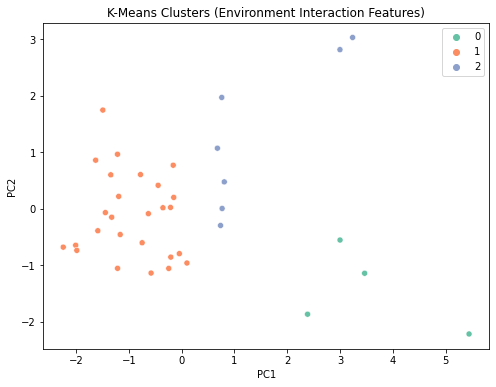

In [53]:
kmeans = KMeans(n_clusters=3, random_state=42)
env_clusters = kmeans.fit_predict(env_data)
features_df["env_cluster"] = env_clusters

# Silhouette scores are used to evaluate the clustering quality.
env_silhouette = silhouette_score(env_data, env_clusters)
print("K-Means (Environment) silhouette score:", env_silhouette)

# Applying PCA to reduce feature dimensions and enable visualization of cluster structures.
pca_env = PCA(n_components=2)
env_pca = pca_env.fit_transform(env_data)
plt.figure(figsize=(8,6))
sns.scatterplot(x=env_pca[:,0], y=env_pca[:,1], hue=env_clusters, palette="Set2")
plt.title("K-Means Clusters (Environment Interaction Features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


#### Clustering for Concept Engagement Analysis using DBSCAN

DBSCAN is used for concept engagement features because it can detect clusters of arbitrary shape and handle noise.
- Distinct patterns highlight how users interact with concepts.

DBSCAN (Concept) found insufficient clusters for silhouette score calculation.


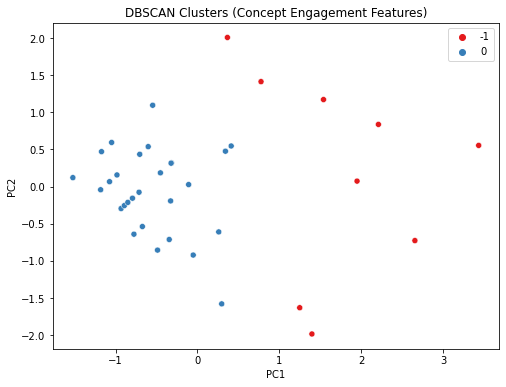

In [54]:
dbscan = DBSCAN(eps=0.8, min_samples=3)  
concept_clusters = dbscan.fit_predict(concept_data)
features_df["concept_cluster"] = concept_clusters

# Silhouette scores are used to evaluate the clustering quality.
if len(set(concept_clusters) - {-1}) > 1:
    concept_silhouette = silhouette_score(concept_data[concept_clusters != -1], 
                                            concept_clusters[concept_clusters != -1])
    print("DBSCAN (Concept) silhouette score:", concept_silhouette)
else:
    print("DBSCAN (Concept) found insufficient clusters for silhouette score calculation.")

# Applying PCA to reduce feature dimensions and enable visualization of cluster structures.
pca_concept = PCA(n_components=2)
concept_pca = pca_concept.fit_transform(concept_data)
plt.figure(figsize=(8,6))
sns.scatterplot(x=concept_pca[:,0], y=concept_pca[:,1], hue=concept_clusters, palette="Set1")
plt.title("DBSCAN Clusters (Concept Engagement Features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#### Compute best parameters

Since no sufficient clustering was found, exploration of multiple (eps, min_samples) combinations to optimize DBSCAN clustering results.

In [33]:
eps_values = [0.3, 0.5, 0.7, 0.9, 1.1]
min_samples_values = [3, 5, 7, 10]

best_score = -1
best_params = (None, None)

for eps in eps_values:
    for min_samp in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(concept_data)  # concept_data is normalized concept features
        
        # Exclude noise points (-1) for silhouette calculation
        if len(set(labels) - {-1}) > 1:
            score = silhouette_score(concept_data[labels != -1], labels[labels != -1])
            print(f"DBSCAN(eps={eps}, min_samples={min_samp}) → silhouette={score:.3f}")
            
            if score > best_score:
                best_score = score
                best_params = (eps, min_samp)
        else:
            print(f"DBSCAN(eps={eps}, min_samples={min_samp}) → insufficient clusters for silhouette.")

print(f"\nBest silhouette score: {best_score:.3f} with eps={best_params[0]}, min_samples={best_params[1]}")


DBSCAN(eps=0.3, min_samples=3) → silhouette=0.636
DBSCAN(eps=0.3, min_samples=5) → insufficient clusters for silhouette.
DBSCAN(eps=0.3, min_samples=7) → insufficient clusters for silhouette.
DBSCAN(eps=0.3, min_samples=10) → insufficient clusters for silhouette.
DBSCAN(eps=0.5, min_samples=3) → insufficient clusters for silhouette.
DBSCAN(eps=0.5, min_samples=5) → insufficient clusters for silhouette.
DBSCAN(eps=0.5, min_samples=7) → insufficient clusters for silhouette.
DBSCAN(eps=0.5, min_samples=10) → insufficient clusters for silhouette.
DBSCAN(eps=0.7, min_samples=3) → insufficient clusters for silhouette.
DBSCAN(eps=0.7, min_samples=5) → insufficient clusters for silhouette.
DBSCAN(eps=0.7, min_samples=7) → insufficient clusters for silhouette.
DBSCAN(eps=0.7, min_samples=10) → insufficient clusters for silhouette.
DBSCAN(eps=0.9, min_samples=3) → silhouette=0.576
DBSCAN(eps=0.9, min_samples=5) → insufficient clusters for silhouette.
DBSCAN(eps=0.9, min_samples=7) → insufficient

#### Parameter Tuning

Re-run DBSCAN with the best parameters (based on silhouette score above).

DBSCAN (Concept) silhouette score: 0.6356291646339488


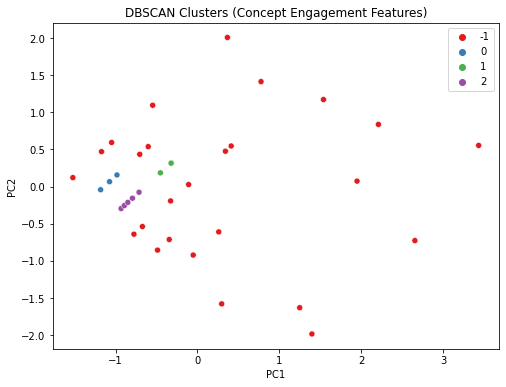

In [34]:
dbscan = DBSCAN(eps=0.3, min_samples=3)  # using best parameters
concept_clusters = dbscan.fit_predict(concept_data)
features_df["concept_cluster"] = concept_clusters

if len(set(concept_clusters) - {-1}) > 1:
    concept_silhouette = silhouette_score(concept_data[concept_clusters != -1], 
                                            concept_clusters[concept_clusters != -1])
    print("DBSCAN (Concept) silhouette score:", concept_silhouette)
else:
    print("DBSCAN (Concept) found insufficient clusters for silhouette score calculation.")

pca_concept = PCA(n_components=2)
concept_pca = pca_concept.fit_transform(concept_data)
plt.figure(figsize=(8,6))
sns.scatterplot(x=concept_pca[:,0], y=concept_pca[:,1], hue=concept_clusters, palette="Set1")
plt.title("DBSCAN Clusters (Concept Engagement Features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#### Combined Clustering Analysis Using PCA-Reduced Features

Merge environment and concept features and apply PCA to reduce dimensions for visualization.
- This combined approach should reveal clusters that reflect both overall user activity and engagement with concepts.

K-Means (Combined) silhouette score: 0.29515226765694763


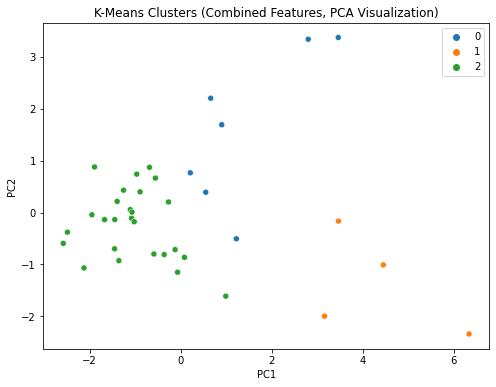

In [35]:
pca_combined = PCA(n_components=2)
combined_pca = pca_combined.fit_transform(combined_data)

kmeans_combined = KMeans(n_clusters=3, random_state=42)
combined_clusters = kmeans_combined.fit_predict(combined_data)
features_df["combined_cluster"] = combined_clusters

combined_silhouette = silhouette_score(combined_data, combined_clusters)
print("K-Means (Combined) silhouette score:", combined_silhouette)

plt.figure(figsize=(8,6))
sns.scatterplot(x=combined_pca[:,0], y=combined_pca[:,1], hue=combined_clusters, palette="tab10")
plt.title("K-Means Clusters (Combined Features, PCA Visualization)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


#### Direct Clustering Without PCA on a Reduced Feature Set

Perform clustering directly on a smaller feature set to gain further insights.
Here, only `session_duration` and `total_concept_interactions` are considered.
- This can highlight overall user engagement with the video content without the complexity of multiple concept-specific features.

K-Means (Direct) silhouette score: 0.5079891292003964


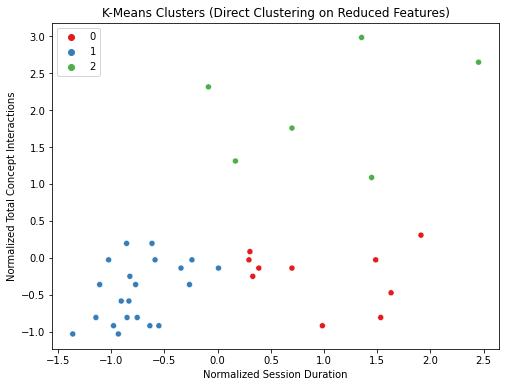

In [36]:
# Select only session_duration and total_concept_interactions for clustering
direct_features = ["session_duration", "total_concept_interactions"]
scaler_direct = StandardScaler()
direct_data = scaler_direct.fit_transform(features_df[direct_features])

# Apply K-Means clustering directly on these features
kmeans_direct = KMeans(n_clusters=3, random_state=42)
direct_clusters = kmeans_direct.fit_predict(direct_data)
features_df["direct_cluster"] = direct_clusters

direct_silhouette = silhouette_score(direct_data, direct_clusters)
print("K-Means (Direct) silhouette score:", direct_silhouette)

plt.figure(figsize=(8,6))
sns.scatterplot(x=direct_data[:,0], y=direct_data[:,1], hue=direct_clusters, palette="Set1")
plt.title("K-Means Clusters (Direct Clustering on Reduced Features)")
plt.xlabel("Normalized Session Duration")
plt.ylabel("Normalized Total Concept Interactions")
plt.show()


#### Integrating Annotation Data with Log Data

In this section:
- Load the JSON annotation data.
- Extract key details such as the concept name (body) and the time range of the annotation.
- Create a DataFrame of annotations.
- Compare the annotation counts with the aggregated log-based concept interactions.
  
*This helps assess whether the annotations (which indicate critical concepts) align with user interactions from the logs.*

In [37]:
import json

# Load the annotation JSON file (adjust the file name/path as necessary)
with open('graph_example.json', 'r', encoding='utf-8') as f:
    annotations = json.load(f)


Extract the relevant information from the JSON.
For each annotation capture:
- The concept (from the "body" field)
- The annotation's creation time (for reference)
- The target's source (the video)
- The start and/or end time from the selector.
  
We assume that time values are in the format "HH:MM:SS.xx^^xsd:dateTime".

In [38]:
def time_to_seconds(time_str):
    """
    Convert a time string to seconds.
    It splits by '^^' and converts the HH:MM:SS.xx part.
    """
    # Remove the datatype suffix
    t = time_str.split("^^")[0]
    # Split the time into hours, minutes, and seconds 
    h, m, s = t.split(":")
    return int(h) * 3600 + int(m) * 60 + float(s)

# list to hold annotation data
annotations_list = []

# Loop through each annotation in the "@graph" array of the JSON
for ann in annotations.get("@graph", []):
    # Only process if the annotation has both "body" and "target" fields
    if "body" in ann and "target" in ann:
        concept = ann["body"]
        created = ann.get("created", None)
        
        # Handle the 'target' field whether it's a dict or a string
        target = ann.get("target", {})
        if isinstance(target, str):
            source = target  # When target is a string, use it directly
            selector = {}    # No selector available
        else:
            source = target.get("source", None)
            selector = target.get("selector", {})
        
        start_time = None
        end_time = None
        if selector.get("type") == "RangeSelector":
            # RangeSelector: has both startSelector and endSelector
            if "startSelector" in selector:
                start_time = time_to_seconds(selector["startSelector"]["value"])
            if "endSelector" in selector:
                end_time = time_to_seconds(selector["endSelector"]["value"])
        elif selector.get("type") == "edu:InstantSelector":
            # InstantSelector: only one time value available
            start_time = time_to_seconds(selector["value"])
        
        annotations_list.append({
            "concept": concept,
            "created": created,
            "source": source,
            "start_time": start_time,
            "end_time": end_time
        })

# Convert the list of annotations to a DataFrame
annotations_df = pd.DataFrame(annotations_list)
print(annotations_df.head().to_string(index=False))


                     concept                    created            source  start_time  end_time
     concept_cloud_computing 2024-11-30T09:46:52.820303 video_zTcsSwKffL4      385.42       NaN
concept_infrastruttura_cloud 2024-11-30T09:46:52.820303 video_zTcsSwKffL4      157.58       NaN
      concept_livello_fisico 2024-11-30T09:46:52.820303 video_zTcsSwKffL4      159.28     168.3
    concept_modello_di_cloud 2024-11-30T09:46:52.820303 video_zTcsSwKffL4      201.78       NaN
            concept_servizio 2024-11-30T09:46:52.820303 video_zTcsSwKffL4       13.28       NaN


#### Comparing Annotation Counts with Log-Based Concept Interactions

Logs dataframe contains concept-specific columns (e.g., "concept_modello_di_cloud", "concept_PaaS", etc.).
Compute the number of annotations per concept and compare them with the aggregated counts from our logs.
  
*What to look for:*  
- Concepts with higher annotation counts also have higher interaction counts in the logs?
- Discrepancies might indicate areas where the content is critical or possibly confusing.

In [ ]:
# Count the number of annotations per concept from the annotations DataFrame
annotation_counts = annotations_df["concept"].value_counts().reset_index()
annotation_counts.columns = ["concept", "annotation_count"]
print("Annotation Counts:")
print(annotation_counts)

# Use the valid_concept_cols variable (which should contain only the correct concept names)
print("Valid concept columns:", valid_concept_cols)

# Sum the interactions across all sessions for each valid concept
log_concept_counts = features_df[valid_concept_cols].sum().reset_index()
log_concept_counts.columns = ["concept", "log_count"]
print("\nLog-Based Concept Interaction Counts:")
print(log_concept_counts)

# Merge the two counts into one DataFrame for comparison
comparison_df = pd.merge(annotation_counts, log_concept_counts, on="concept", how="outer").fillna(0)
print("\nComparison of Annotation and Log Counts:")
print(comparison_df)


Annotation Counts:
                           concept  annotation_count
0          concept_cloud_computing                 5
1         concept_modello_di_cloud                 5
2                 concept_servizio                 5
3     concept_infrastruttura_cloud                 3
4              concept_On-Premises                 2
5   concept_fornitore_del_servizio                 2
6           concept_livello_fisico                 1
7         concept_risorse_hardware                 1
8                 concept_software                 1
9                     concept_PaaS                 1
10               conll_zTcsSwKffL4                 1
11        concept_livello_astratto                 1
12          concept_caratteristica                 1
13                    concept_SaaS                 1
14                    concept_IaaS                 1
Valid concept columns: ['concept_servizio', 'concept_fornitore_del_servizio', 'concept_livello_fisico', 'concept_caratteristica', 'co

In [48]:
# Check correlation between annotation and log counts
correlation = comparison_df[["annotation_count", "log_count"]].corr().iloc[0,1]
print(f"\nCorrelation between annotation and log interaction counts: {correlation:.3f}")



Correlation between annotation and log interaction counts: 0.258


The correlation between annotated concept importance and actual user interactions is 0.26, indicating a modest alignment.

                           concept  annotation_count  log_count
0          concept_cloud_computing                 5       59.0
1         concept_modello_di_cloud                 5       49.0
2                 concept_servizio                 5        4.0
3     concept_infrastruttura_cloud                 3       23.0
4              concept_On-Premises                 2        8.0
5   concept_fornitore_del_servizio                 2       21.0
6           concept_livello_fisico                 1       10.0
7         concept_risorse_hardware                 1       24.0
8                 concept_software                 1        9.0
9                     concept_PaaS                 1       26.0
10               conll_zTcsSwKffL4                 1        0.0
11        concept_livello_astratto                 1       28.0
12          concept_caratteristica                 1       68.0
13                    concept_SaaS                 1       37.0
14                    concept_IaaS      

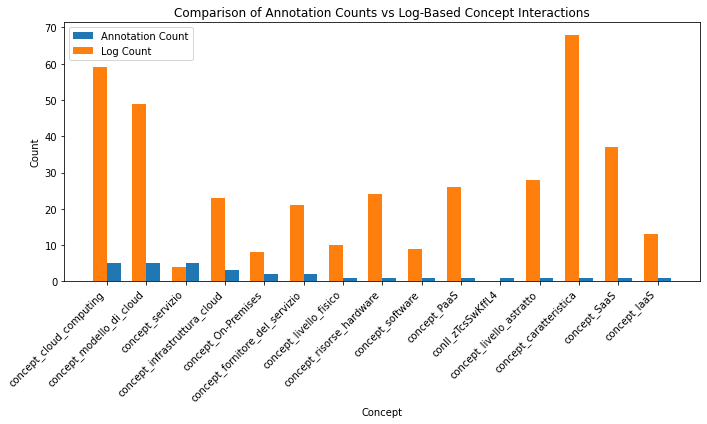

In [50]:
# Custom colors for bars
log_color = "#ff7f0e"  # Orange for log counts
annotation_color = "#1f77b4"  # Blue for annotation counts

# Plot a side-by-side bar chart for visual comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

print(comparison_df)

plt.bar(x + width/2, comparison_df["annotation_count"], width, color=annotation_color, label="Annotation Count")
plt.bar(x - width/2, comparison_df["log_count"], width, color=log_color, label="Log Count")
plt.xlabel("Concept")
plt.ylabel("Count")
plt.title("Comparison of Annotation Counts vs Log-Based Concept Interactions")
plt.xticks(x, comparison_df["concept"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


#### Session-Specific Engagement Analysis

This section focuses on analyzing individual session behavior to assess alignment between user interactions and annotated concept importance.

                           concept  log_count  annotation_count
0                 concept_servizio          0                 5
1   concept_fornitore_del_servizio          0                 2
2           concept_livello_fisico          0                 1
3           concept_caratteristica          0                 1
4                     concept_IaaS          1                 1
5         concept_risorse_hardware          0                 1
6     concept_infrastruttura_cloud          0                 3
7              concept_On-Premises          0                 2
8                     concept_SaaS          2                 1
9         concept_modello_di_cloud          0                 5
10                    concept_PaaS          0                 1
11         concept_cloud_computing          0                 5
12                concept_software          0                 1
13        concept_livello_astratto          0                 1


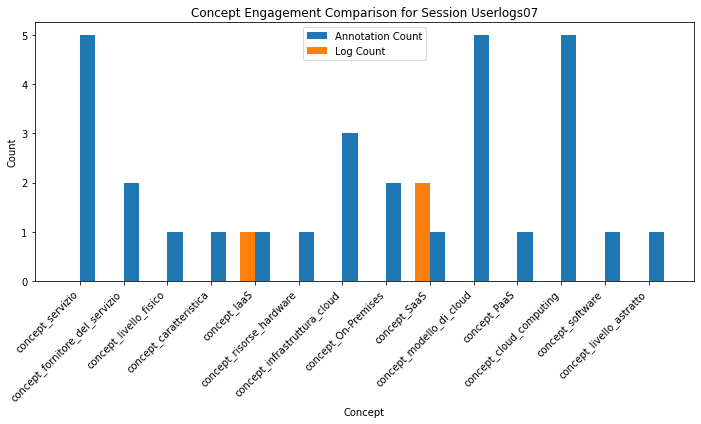

In [45]:
# Select a session ID for deep-dive analysis
session_id = features_df["sessionID"].iloc[0]  # or replace with specific session ID like "Userlogs07"

session_data = features_df[features_df["sessionID"] == session_id]

# Extract concept-specific columns from the session
session_concept_counts = session_data[valid_concept_cols].iloc[0]  # Series: index = concept, value = log count

# Filter annotation_counts to include only valid concepts
filtered_annotation_counts = annotation_counts[annotation_counts["concept"].isin(valid_concept_cols)]

# Combine the session and annotation counts into a single DataFrame for comparison
comparison_session = pd.DataFrame({
    "concept": valid_concept_cols,
    "log_count": session_concept_counts.values,
    "annotation_count": filtered_annotation_counts.set_index("concept").reindex(valid_concept_cols)["annotation_count"].fillna(0).values
})

print(comparison_session)

# Custom colors for bars
log_color = "#ff7f0e"  # Orange for log counts
annotation_color = "#1f77b4"  # Blue for annotation counts

# Plot a side-by-side bar chart for visual comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(comparison_session))
width = 0.35

plt.bar(x + width/2, comparison_session["annotation_count"], width, color=annotation_color, label="Annotation Count")
plt.bar(x - width/2, comparison_session["log_count"], width, color=log_color, label="Log Count")
plt.xlabel("Concept")
plt.ylabel("Count")
plt.title(f"Concept Engagement Comparison for Session {session_id}")
plt.xticks(x, comparison_session["concept"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()
